## Linear Regression

***Author: Rabindra Nepal***

*Email: rnepal2@unl.edu*


This notebook implements and evaluates followings:

1. Implementation of the iterative optimization Gradient Descent algorithms for
solving a Linear Regression problem
2. Implementation of various regularization techniques
3. Polynomial regression
4. Learning curve

In [20]:
import math
import os
import random
import itertools
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Polynomial and interaction features generation

In [4]:
# helper function to calculate all combinations
def combinations(n_features, degree):
    joined_string = ''
    item = 0
    while True:
        joined_string += str(item)
        if item == n_features-1:
            break
        item += 1
    _combinations = list(itertools.combinations_with_replacement(joined_string, degree))
    # tuples to lists
    combination_lists = [list(tup) for tup in _combinations]
    
    for i, tup in enumerate(combination_lists):
        for j in range(len(tup)):
            combination_lists[i][j] = int(combination_lists[i][j])
    return combination_lists

def polynomialFeatures(X, degree=None):
    '''
        parameters:
            X: ndarray with columns number of features and rows number of data points/samples
            degree: degree of the polynomial features: default = 1
        returns:
            new feature matrix including all new features of specified degree
    '''
    X = np.array(X, dtype=np.float64)
    if not degree:
        degree = 1
        return X
    
    n_samples, n_features = X.shape[0], X.shape[1]
    # total number of output features
    combinations_list = []
    for d in range(1, degree+1):
        combinations_list += combinations(n_features, d)
    nout_features = len(combinations_list)
    
    # creating an empty array to fill required features
    X_empty = np.empty((n_samples, nout_features), dtype=X.dtype)
    for i, comb in enumerate(combinations_list):
        X_empty[:, i] = X[:, tuple(comb)].prod(1)

    return X_empty

In [6]:
# test
A = np.array([[1, 2], [2, 4], [3, 6]])

# polynomial features
polynomialFeatures(A, 3)

array([[  1.,   2.,   1.,   2.,   4.,   1.,   2.,   4.,   8.],
       [  2.,   4.,   4.,   8.,  16.,   8.,  16.,  32.,  64.],
       [  3.,   6.,   9.,  18.,  36.,  27.,  54., 108., 216.]])

#### Mean Squared Error

In [8]:
def mse(Y_true, Y_pred):
    '''
        parameters:
            Y_true: (ndarray)  1D array containing float data: true values
            Y_pred: (ndarray)  1D array containing float data: predicted values
        return:
            cost: mean squared error between Y_true and Y_pred
        1D: should be represented as column vectors
    '''
    assert Y_true.shape == Y_pred.shape 
    
    if Y_true.shape[1] == Y_pred.shape[1] != 1:
        raise ValueError('Y_pred and Y_true should be column vectors - not a 1D array')
    
    _sum = np.sum([(Y_true[i][0] - Y_pred[i][0])**2 for i in range(Y_true.shape[0])])
    
    return _sum/(Y_true.shape[0])  

In [9]:
def r2_score(y_true, y_pred):
    '''
        parameters:
            y_true: 1-D column vector of true values
            y_pred: 1-D column vector of predicted values
        returns:
            r2_score: R^2 coefficient of determination
    '''
    assert len(y_true) == len(y_pred)
    sum_ymyh2 = 0.0
    for i in range(len(y_true)):
        sum_ymyh2 += (y_true[i][0] - y_pred[i][0])**2
    
    average_y = y_true.flatten().mean()
    sum_ymyaverage = 0.0
    for i in range(len(y_true)):
        sum_ymyaverage += (y_true[i][0] - average_y)**2
        
    return 1.0 - (sum_ymyh2/sum_ymyaverage)

In [10]:
# test, required 1-D columns
y_true = np.array([[3], [-0.5], [2], [7]])
y_pred = np.array([[2.5], [0.0], [2], [8]])

In [11]:
mse(y_true, y_pred)

0.375

In [12]:
r2_score(y_true, y_pred)

0.9486081370449679

### Learning Curve

In [13]:
# returns the k^th fold of train/validation dataset out of folds
def k_partition(X, y, k_fold, folds):
    '''
    parameters:
        data: [num_sample, num_features] or x_train
        labels: [num_sample] or y_train
        nth_fold: ith_fold number out ot folds
        folds: total number of folds
    returns:
        n^(th)-fold train and test data
    
    '''
    assert len(X) == len(y)
    
    size = int(len(X)/folds)
    test_indices = np.arange(k_fold*size, (k_fold+1)*size)
    train_indices = np.delete(np.arange(len(X)), test_indices)
    
    X_test, y_test = np.take(X, test_indices, axis=0), np.take(y, test_indices)
    X_train, y_train = np.take(X, train_indices, axis=0), np.take(y, train_indices)
    
    # reshaping ys as column vectors
    y_train = y_train.reshape(len(y_train), 1)
    y_test = y_test.reshape(len(y_test), 1)
    
    return (X_train, X_test), (y_train, y_test)

In [14]:
# for a train_size: it returns cross-validation train/validation scores
def learning_curve(model, X, y, cv=3, train_size=1.0, learning_rate=0.01, 
                   epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    
    # X, y = shuffle(X, y, random_state=19)
    # preparing X data
    if isinstance(train_size, int):
        X = X[:train_size]
        y = y[:train_size]
        
    if isinstance(train_size, float):
        size = round(train_size * X.shape[0])
        X = X[:size]
        y = y[:size]

    # storing buffers
    train_scores = list(); val_scores = list()
    for fold in range(cv):
        (X_train, X_test), (y_train, y_test) = k_partition(X, y, fold, cv)
        
        # model = LinearRegression()
        model.fit(X_train, y_train, learning_rate=learning_rate, epochs=epochs, 
                      tol=tol, regularizer=regularizer, lambd=lambd)
        # predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        # to 1-D columns
        y_train = y_train.reshape(len(y_train), 1)
        y_test = y_test.reshape(len(y_test), 1)
        
        # root mean square errors
        train_rmse = math.sqrt(mse(y_train, y_train_pred))
        val_rmse = math.sqrt(mse(y_test, y_test_pred))
        
        train_scores.append(train_rmse)
        val_scores.append(val_rmse)
        
    return np.array(train_scores), np.array(val_scores)

#### Polynomial model complexity

In [15]:
from sklearn.preprocessing import StandardScaler
# we can also implement the StandardScaler in pandas dataframe easily shown below:

def scale_normal(df):
    if 'target' not in df.columns.values:
        raise Warning('the target column named target is expected in df')
    for column in df.columns.values:
        # don't normalize target column
        if column == 'target': continue
        mean, sd = df[column].mean(), df[column].std()
        df[column] = df[column].apply(lambda x: (x-mean)/sd)
    return df

Since the above implementation uses pandas.DataFrame as input: I have used the StandardScaler (which are equivalent) in order to avoid back to back conversion from pandas.DataFrame to numpy.ndarray.

In [16]:
def plot_polynomial_model_complexity(model, X, y, cv=3, maxPolynomialDegree=1, learning_rate=0.01, 
                                     epochs=1000, tol=None, regularizer=None, lambd=0.0, **kwargs):
    # store buffers
    degrees = list(); train_scores = list(); val_scores = list()
    for degree in range(1, maxPolynomialDegree+1):
        
        degrees.append(degree)
        
        # adding polynomial features
        Xs = polynomialFeatures(X, degree=degree)
        
        # scaling the features again
        scale = StandardScaler()
        Xs = scale.fit_transform(Xs)
        
        temp_trains = list(); temp_vals = list()
        for fold in range(cv):
            (X_train, X_test), (y_train, y_test) = k_partition(Xs, y, fold, cv)
            model.fit(X_train, y_train, learning_rate=learning_rate, epochs=epochs, 
                          tol=tol, regularizer=regularizer, lambd=lambd)

            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            y_train = y_train.reshape(len(y_train), 1)
            y_test = y_test.reshape(len(y_test), 1)

            # root mean square errors
            train_rmse = math.sqrt(mse(y_train, y_train_pred))
            val_rmse = math.sqrt(mse(y_test, y_test_pred))

            temp_trains.append(train_rmse)
            temp_vals.append(val_rmse) 

        train_scores.append(np.array(temp_trains).mean())
        val_scores.append(np.array(temp_vals).mean())
    
    # plotting
    print('train scores: ', train_scores)
    print('validation scores: ', val_scores)
    plt.scatter(degrees, train_scores, c='b')
    plt.plot(degrees, train_scores, c='b', label='training score')
    plt.scatter(degrees, val_scores, c='r')
    plt.plot(degrees, val_scores, c='r', label='validation score')
    plt.legend()
    plt.xlabel('Polynomial Degree')
    plt.ylabel('RMSE')
    # save fig
    plt.savefig('pol-complexity.pdf')
    plt.show()

### Linear Regression Model

Here, we implement the linear regression model class using batch gradient descent algorith. The weight/theta matrix in the algorithm is updated as follow - depending upon the regularization conditions.

- Without regularization:
\begin{align}
\vec{\theta} := \vec{\theta} - \frac{\eta}{m} \vec{X}^T \cdot (\vec{X}.\vec{\theta} - \vec{y})
\end{align}

- With $l_2-$regularization:
\begin{align}
J(\vec{\theta}) = \frac{1}{2m} \sum_{i=0}^m (y_i - \vec{\theta}^T \vec{X}_i)^2 + \frac{\lambda}{2m} || \vec{\theta} ||^2
\end{align}


\begin{align}
\vec{\theta} := \vec{\theta} - \frac{\eta}{m} \vec{X}^T \cdot (\vec{X}.\vec{\theta} - \vec{y}) - \frac{\eta \lambda}{m}\vec{\theta}
\end{align}

- With $l_1-$regularization:
\begin{align}
J(\vec{\theta}) = \frac{1}{2m} \sum_{i=0}^m (y_i - \vec{\theta}^T \vec{X}_i)^2 + \frac{\lambda}{2m} || \vec{\theta} ||
\end{align}


\begin{align}
\vec{\theta} := \vec{\theta} - \frac{\eta}{m} \vec{X}^T \cdot (\vec{X}.\vec{\theta} - \vec{y}) - \frac{\eta \lambda}{m} sign( \vec{\theta})
\end{align}

In [17]:
class LinearRegression:
    
    def __init__(self):
        self.error0 = None
        self.theta = None
        self.intercept_ = None
        self.coef_ = None
    
    # SOME HELPER FUNCTIONS
    # returns non-regularized cost
    def nonregularized_cost(self, X, y, theta, lambd):
        m = X.shape[0]
        return 1./(2*m)*(sum(y - np.matmul(X, theta))**2)[0]
    
    # returns cost with l1-regularization
    def l1_cost(self, X, y, theta, lambd):
        m = X.shape[0]
        return 1./(2*m)*(sum(y - np.matmul(X, theta))**2)[0] + lambd/(2*m) * np.linalg.norm(theta)
    
    # returns cost with l2-regularization
    def l2_cost(self, X, y, theta, lambd):
        m = X.shape[0]
        return 1./(2*m)*(sum(y - np.matmul(X, theta))**2)[0] + lambd/(2*m) * (np.linalg.norm(theta))**2
    
    # decides wether to force break due to tolerance 
    def forced_break(self, epoch, error, tol):
        force_break = False
        if epoch == 0:
            self.error0 = error
        if tol and epoch > 0:
            if error > self.error0 - tol:
                force_break = True
        self.error0 = error
        return force_break
    
    def fit(self, X, y, learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, **kwargs):
        
        # adding a unit column in the input data: to find intercept
        X = np.c_[np.ones((X.shape[0], 1)), X]
        # reshape y as 1-D column vector
        y = np.array(y).reshape(len(y), 1)
        
        # number of samples and features
        n_samples, n_features = X.shape[0], X.shape[1]
        
        # initializing theta/weight
        np.random.seed(seed=100)
        theta_hat = np.random.rand(n_features, 1)
        force_break = False
        for epoch in range(epochs):
            # updates depending upon regularization
            if not regularizer:
                theta_hat = theta_hat - (learning_rate/n_samples) * np.dot(X.T, np.dot(X, theta_hat) - y)
                error = self.nonregularized_cost(X, y, theta_hat, lambd)
                
            if regularizer == 'l1':
                theta_hat = theta_hat - (learning_rate/n_samples) * np.dot(X.T, np.dot(X, theta_hat) - y) - \
                        ((learning_rate*lambd)/n_samples) *  np.sign(theta_hat)
                error = self.l1_cost(X, y, theta_hat, lambd)
                
            if regularizer == 'l2':
                theta_hat = theta_hat - (learning_rate/n_samples) * np.dot(X.T, np.dot(X, theta_hat) - y) - \
                        ((learning_rate*lambd)/n_samples) *  theta_hat
                error = self.l2_cost(X, y, theta_hat, lambd)
            
            # Forced break?: if tolerance is given
            if self.forced_break(epoch, error, tol) is True:
                print('tolerance break at epoch: ', epoch)
                break
        # update theta: to access from predict method after fit
        self.theta = theta_hat
        # print('self.theta: ', self.theta.shape)
        self.intercept_ = theta_hat[0]
        self.coef_ = theta_hat[1:]
    
    def predict(self, X):
        # also adding ones column into test data: gives intercept 
        X = np.c_[np.ones((X.shape[0], 1)), X]
        if self.theta is None:
            raise ValueError('The model is not fitted yet!')
        return np.dot(X, self.theta)

#### Testing the model implementation...

In [629]:
# dummy data
a = np.array([[1, 2], [2, 4], [4, 7]])
b = np.array([[2], [4], [6]])

# model
lg = LinearRegression()
lg.fit(a, b, learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=1.0)

# prediction
y_pred = lg.predict(a)

In [630]:
print('y_true: ', b)
print('y_pred: ', y_pred)

y_true:  [[2]
 [4]
 [6]]
y_pred:  [[2.13119471]
 [3.66872458]
 [6.14833317]]


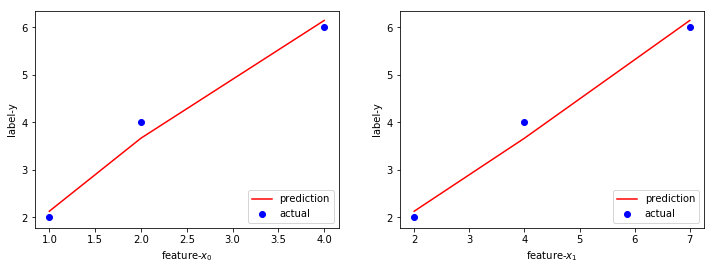

In [631]:
# visualizing the model results

fig = plt.figure(figsize=(12, 4))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(a[:, 0], b, c='b', label='actual')
ax1.plot(a[:, 0], y_pred, c='r', label='prediction')
ax1.set_ylabel('label-y')
ax1.legend(loc='lower right');
ax1.set_xlabel('feature-$x_0$')

ax2.scatter(a[:, 1], b, c='b', label='actual')
ax2.plot(a[:, 1], y_pred, c='r', label='prediction')
ax2.set_ylabel('label-y')
ax2.set_xlabel('feature-$x_1$');
ax2.legend(loc='lower right');

In [632]:
# mean squared error
mse(b, y_pred)

0.04965272836241565

In [633]:
# r2_score 
r2_score(b, y_pred)

0.9813802268640941

### Data Processing

#### winequality-red dataset

In [725]:
# loading dataset
df = pd.read_csv('./winequality-red.csv')
# df.head()

In [726]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [727]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


#### shuffling the dataframe.....

In [728]:
df = df.sample(frac=1.0)

#### Pairplot: looking into data colinearity

C:\Users\nepal\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


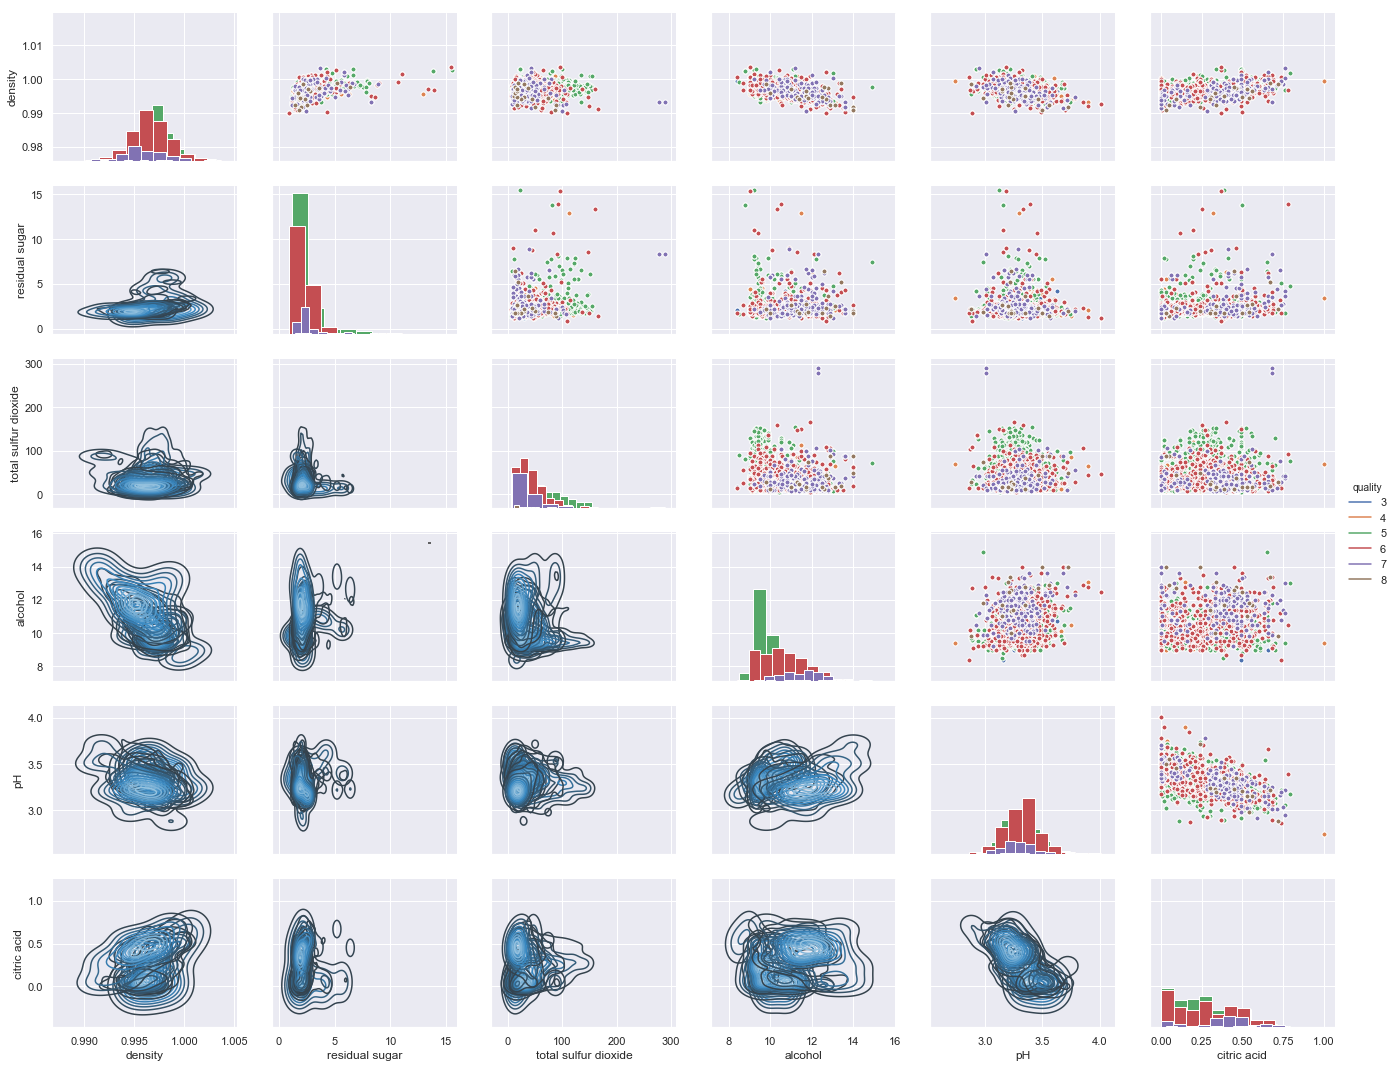

In [744]:
# df.corr()['quality'].abs().sort_values(ascending=False)

sns.set(style='darkgrid')

variables = ['density', 'residual sugar', 'total sulfur dioxide', 'alcohol', 'pH', 'citric acid']
g = sns.PairGrid(df, hue='quality' , vars=variables, aspect=1.25)

g = g.map_diag(plt.hist, edgecolor="w")
g = g.map_upper(plt.scatter, edgecolor="w", s=25)
g = g.map_lower(sns.kdeplot, cmap="Blues_d", lw=1)
g = g.add_legend()

#### partition function: train_test_split to divide training and validation dataset

In [639]:
# returns the train, test splitting
# train_test_split equivalent
def partition(x_train, y_train, t=0.2):
    assert len(x_train) == len(y_train)
    validation_size = int(t*len(x_train))
    # here we are not reshuffling the data 
    # as the passed data is expected to be shuffled before passing
    x_test, y_test = x_train[:validation_size], y_train[:validation_size]
    x_train, y_train = x_train[validation_size:], y_train[validation_size:]
    return (x_train, x_test), (y_train, y_test)

## Model Evaluation

#### kFold cross-validation

In [18]:
# returns the prediction dictionary for each fold of cross validation
def for_each_fold(fold, folds, data, labels, model, model_args=None, error_function=None):

    (x_train, x_test), (y_train, y_test) = k_partition(data, labels, fold, folds)
    
    if model_args:
        if 'learning_rate' in model_args.keys():
            learning_rate = model_args['learning_rate']
        if 'epochs' in model_args.keys():
            epochs = model_args['epochs']
        if 'regularizer' in model_args.keys():
            regularizer = model_args['regularizer']
        if 'lambd' in model_args.keys():
            lambd = model_args['lambd']
    
    model.fit(x_train, y_train, learning_rate=learning_rate, epochs=epochs, regularizer=regularizer, lambd=lambd)
    y_pred = model.predict(x_test)

    # Based on the error_function passed
    if error_function == 'mse': 
        error = mse(y_test, y_pred)
    else:
        raise ValueError('%s error function is not defined.' % error_function)
        
    return {'expected values': y_test, 
            'predicted values': y_pred, 
            'errors': [error]}

# Cross-Validation function
def kFold(folds, data, labels, model, model_args=None, error_function=None):
    '''
    parameters:
        folds: an integer number of folds.
        data: a numpy array with rows representing data samples and columns representing features.
        labels: a numpy array with labels corresponding to each row of training_features.
        model: an object with the fit and predict functions. 
        model_args: a dictionary of arguments to pass to the classification algorithm.
        error_function: Returns error value between predicted and true labels. For example: mse 
        verbose: 0: don't print any progress message
                 1: print the progress message
    returns:
        a dictionary with: expected values, predicted values, average error
    '''
    
    if error_function is None:
        error_function = 'mse'
        
    predictions = dict()    
    for fold in range(folds):
        out = for_each_fold(fold, folds, data, labels, model, error_function=error_function , model_args=model_args)
        # storing results into dict - predictions
        for key in out.keys():
            if key not in predictions.keys():
                predictions[key] = list(out[key])
            else:
                predictions[key].extend(list(out[key]))

    # formatting output
    for key in predictions.keys():
        predictions[key] = np.array(predictions[key])
    return predictions

#### Hyperparameter tuning and Model selection

In [641]:
# hyperparameters lists
lambdas = [10.0, 1.0, 0, 0.1, 0.01]
learning_rates = [0.005, 0.01, 0.001]
regularizers = ['l1', 'l2']

In [642]:
# custom greedy search of best parameters
def customGridSearchCV(data, labels, folds=3, epochs=1000):
    # dict buffer
    best_params = dict()
    err0 = math.inf
    # greedy search 
    for lambd in lambdas:
        for lr in learning_rates:
            for r in regularizers:
                model = LinearRegression()
                # model_args dict
                model_args = {'learning_rate': lr, 'epochs': 1000, 'regularizer': r, 'lambd': lambd}
                # cross validation
                cross_vals = kFold(folds, data, labels, model, model_args=model_args, error_function='mse')
                # mean squared error
                err = cross_vals['errors'].mean() # mean of the errors from k-fold cross-validation
                if err < err0:
                    best_params['lambda'] = lambd
                    best_params['learning_rate'] = lr
                    best_params['regularizer'] = r
                    best_params['mse'] = err
                    err0 = err
    return best_params

Here, I don't carry out feature analysis for feature selection here -  which was done for this same dataset in last recitation. I select the same features as done before which is dropping only a single feature 'free sulfur dioxide'.

In [643]:
y = df['quality']
X = df.drop(columns=['quality', 'free sulfur dioxide'], inplace=False)

In [644]:
# standardization of the features
# Note that this standardization of features is important: 
# otherwise leads to divergence quickly for fairly normal learning rate

scale = StandardScaler()
X = scale.fit_transform(X)
X = pd.DataFrame(X)

In [645]:
(X_train, X_test), (y_train, y_test) = partition(X, y, t=0.2)
(X_train, X_test), (y_train, y_test) = (X_train.values, X_test.values), (y_train.values, y_test.values)

In [195]:
# Hyperparameter tuning
# GridSearchCV

customGridSearchCV(X.values, y.values, folds=3, epochs=1000)

{'lambda': 10.0,
 'learning_rate': 0.01,
 'regularizer': 'l1',
 'mse': 0.426688789050568}

#### Model evaluation on test data

In [646]:
model = LinearRegression()
model.fit(X_train, y_train, learning_rate=0.01, epochs=1000, regularizer='l1', lambd=10.0)

# prediction on test data
y_pred = model.predict(X_test)

In [647]:
# mean squared error

print('mean squared error: ', mse(y_test.reshape(len(y_test), 1), y_pred))
print('r2_score: ', r2_score(y_test.reshape(len(y_test), 1), y_pred))

mean squared error:  0.4318235849966847
r2_score:  0.32010768918109445


#### Learning curve plot

In [648]:
# plots the learning curve for different training size
def plot_learning_curve(X_train, y_train):
    train_sizes = list()
    train_scores = list()
    test_scores = list()
    for train_size in [0.01, 0.03, 0.04, 0.05, 0.1, 0.35, 0.5, 0.7, 0.9, 1.0]:
        train_sizes.append(train_size)
        # training and validation rmse
        train_score, val_score =  learning_curve(LinearRegression(), X_train, y_train, cv=3, train_size=train_size,  
                                              learning_rate=0.001, epochs=20000, regularizer='l1', lambd=10.0)
        train_scores.append(train_score.mean())
        test_scores.append(val_score.mean())

    # plotting learning curve
    train_sizes = [i*len(X_train) for i in train_sizes]
    plt.scatter(train_sizes, train_scores);
    plt.plot(train_sizes, train_scores, label='training score', c='b');
    plt.scatter(train_sizes, test_scores);
    plt.plot(train_sizes, test_scores, label='validation score', c='r');
    plt.legend()
    plt.xlabel('training size')
    plt.ylabel('RMSE')
    plt.savefig('learning_curve1.pdf')
    plt.show()

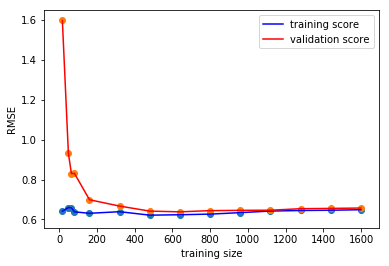

In [581]:
plot_learning_curve(X.values, y.values)

#### Learning curve for polynomial $d= 3$ features

In [655]:
y_new = df.quality
X_new = df.drop(columns=['quality', 'free sulfur dioxide'], inplace=False)

In [650]:
# preparing training data with d = 3
X_new = polynomialFeatures(X_new.values, degree=3)

scale = StandardScaler()
X3ds = scale.fit_transform(X_new)

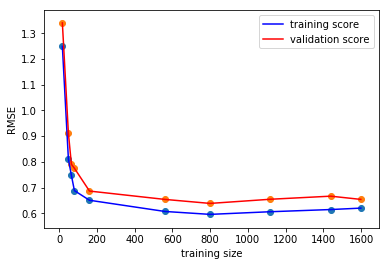

In [612]:
plot_learning_curve(X3ds, y_new.values)

#### rmse for different polynomial degrees

Since the adaptive learning rate is not implemented, this functions diverges quickly for the higher polynomial degrees even for a reasonable value of the learning rate. The remedy is to decrease the learning rate and increase the number of epochs at the same time. But it will apparently increase the computationaly expenses. Here, I found that obtaining the accurate graph for degree 5 is very difficult, however it works reasonably okay upto degree 4 with some compromises. Note that this is after the standard features scaling even after obtaining the augmented features.

train scores:  [0.6461017730219997, 0.6306762640937108, 0.6243259062742709]
validation scores:  [0.6531904579468689, 0.6427806893330446, 0.6441129217215024]


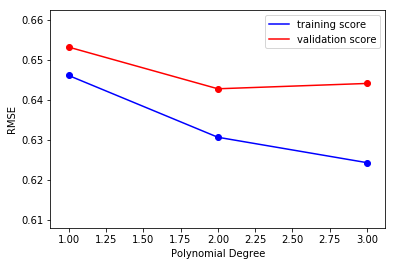

In [674]:
plot_polynomial_model_complexity(LinearRegression(), X_new.values, y_new.values, cv=3, maxPolynomialDegree=3, 
                                 learning_rate=0.005, epochs=10000, tol=None, regularizer='l1', lambd=10.0)

In [683]:
# only upo degree 3
train_scores3 = [0.64610099196131, 0.6306765534434424, 0.624326535285746]
validation_scores3=  [0.6531871069095337, 0.6427696019194754, 0.6441739280162961]

In [684]:
# upto degree 5
train_scores=  [0.6464699927613102, 0.6424380051726262, 0.6336475164530572, 0.6304612053172227, 0.6397075181686166]
validation_scores = [0.6537981128087399, 0.6595492148048397, 0.688986273490967, 0.7392448080613065, 1.3910439497611424]

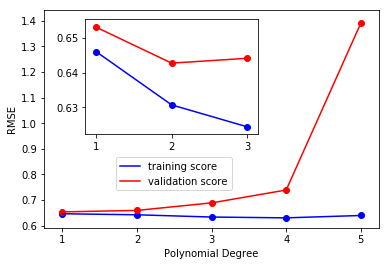

In [720]:
# merging figures
# the data are from two different runs
# for d=5: learning rate should be loweered and epochs to be increased
# in order to get the same accuracy as that for d =3. Kinda expensive
# created inset to illustrate the d=3 region clearly in the figure

fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.22, 0.45, 0.40, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot([1, 2, 3, 4, 5],train_scores, color='blue', label='training score')
ax1.scatter([1, 2, 3, 4, 5], train_scores, color='blue')
ax1.plot([1, 2, 3, 4, 5], validation_scores, color='red', label='validation score')
ax1.scatter([1, 2, 3, 4, 5], validation_scores, color='red')
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('RMSE')

ax1.legend(loc='lower left', bbox_to_anchor=(0.2,0.15))

# inset
ax2.plot([1, 2, 3], train_scores3, color='blue')
ax2.scatter([1, 2, 3], train_scores3, color='blue')
ax2.plot([1, 2, 3], validation_scores3, color='red')
ax2.scatter([1, 2, 3], validation_scores3, color='red')
ax2.set_xticks([1, 2, 3])

plt.savefig('complexity.pdf')
plt.show()

### Stochastic Gradient Descent Linear Regression

Here, we update weights (theta) using stochastic gradient descent algorithm where the coefficient is updated with only a single instance of training data point at at time. Therefore, this is very little different from previous class. An additional for loop is introduced to train for each epoch with a single instance at a time. 

In [232]:
# linear regression: with stochastic gradient descent
# different from LinearRegression: only in fit method: 
# where we update theta with randomly selected sample point at a time.
class stochasticLinearRegression:
    
    def __init__(self):
        self.error0 = None
        self.theta = None
        self.intercept_ = None
        self.coef_ = None
    
    # SOME HELPER FUNCTIONS
    # returns non-regularized cost
    def nonregularized_cost(self, X, y, theta, lambd):
        m = X.shape[0]
        return 1./(2*m)*(sum(y - np.matmul(X, theta))**2)[0]
    
    # returns cost with l1-regularization
    def l1_cost(self, X, y, theta, lambd):
        m = X.shape[0]
        return 1./(2*m)*(sum(y - np.matmul(X, theta))**2)[0] + lambd/(2*m) * np.linalg.norm(theta)
    
    # returns cost with l2-regularization
    def l2_cost(self, X, y, theta, lambd):
        m = X.shape[0]
        return 1./(2*m)*(sum(y - np.matmul(X, theta))**2)[0] + lambd/(2*m) * (np.linalg.norm(theta))**2
    
    # decides wether to force break due to tolerance 
    def forced_break(self, epoch, error, tol):
        force_break = False
        if epoch == 0:
            self.error0 = error
        if tol and epoch > 0:
            if error > self.error0 - tol:
                force_break = True
        self.error0 = error
        return force_break
    
    def fit(self, X, y, learning_rate=0.01, epochs=100, tol=None, regularizer=None, lambd=0.0, **kwargs):
        
        # adding a unit column in the input data: to find intercept
        X = np.c_[np.ones((X.shape[0], 1)), X]
        # reshape y as 1-D column vector
        y = np.array(y).reshape(len(y), 1)
        # number of samples and features
        n_samples, n_features = X.shape[0], X.shape[1]
        # initializing theta/weight
        np.random.seed(seed=100)
        theta_hat = np.random.rand(n_features, 1)
        force_break = False
        for epoch in range(epochs):
            # training with random instance each time
            # this extra loop for stochastic gradient descent update
            numbers = np.random.randint(0, len(X), (len(X), ))
            for i in numbers:
                # ith sample points
                X_i, y_i = np.array([X[i]]), np.array([y[i]])
                if not regularizer:
                    theta_hat = theta_hat - (learning_rate/n_samples) * np.dot(X_i.T, np.dot(X_i, theta_hat) - y_i)
                    error = self.nonregularized_cost(X_i, y_i, theta_hat, lambd)

                if regularizer == 'l1':
                    theta_hat = theta_hat - (learning_rate/n_samples) * np.dot(X_i.T, np.dot(X_i, theta_hat) - y_i) - \
                            ((learning_rate*lambd)/n_samples) *  np.sign(theta_hat)
                    error = self.l1_cost(X_i, y_i, theta_hat, lambd)

                if regularizer == 'l2':
                    theta_hat = theta_hat - (learning_rate/n_samples) * np.dot(X_i.T, np.dot(X_i, theta_hat) - y_i) - \
                            ((learning_rate*lambd)/n_samples) *  theta_hat
                    error = self.l2_cost(X_i, y_i, theta_hat, lambd)

            # Forced break?: if tolerance is given
            if self.forced_break(epoch, error, tol) is True:
                print('tolerance break at epoch: ', epoch)
                break
        # update theta: to access from predict method after fit
        self.theta = theta_hat
        # print('self.theta: ', self.theta.shape)
        self.intercept_ = theta_hat[0]
        self.coef_ = theta_hat[1:]
    
    def predict(self, X):
        # also adding ones column into test data: gives intercept 
        X = np.c_[np.ones((X.shape[0], 1)), X]
        if self.theta is None:
            raise ValueError('The model is not fitted yet!')
        return np.dot(X, self.theta)

**Comparing stochastic gradient-descent and batch gradient-descent models....**

In [256]:
slg = stochasticLinearRegression()
slg.fit(X_train, y_train, learning_rate=0.01, epochs=1000 , regularizer='l1', lambd=10.0)

In [257]:
print('mean-squared error: ', mse(y_test.reshape(len(y_test), 1), slg.predict(X_test)))

mean-squared error:  32.17477443745072


In [258]:
slg.theta

array([[ 6.13806319e-05],
       [-3.55327564e-05],
       [-4.75515081e-06],
       [-1.74189095e-05],
       [ 4.04792849e-05],
       [-9.01829869e-06],
       [ 1.51492785e-04],
       [ 6.00629184e-05],
       [ 8.38608272e-05],
       [-9.07312985e-05],
       [ 5.46952360e-05]])

In [240]:
# batch gradient descent

blg = LinearRegression()
blg.fit(X_train, y_train, learning_rate=0.01, epochs=1000 , regularizer='l1', lambd=10.0)

In [241]:
print('mean-squared error: ', mse(y_test.reshape(len(y_test), 1), blg.predict(X_test)))

mean-squared error:  0.38056816552729555


In [259]:
blg.theta

array([[ 5.63621012e+00],
       [-4.67242325e-02],
       [-1.77493399e-01],
       [ 5.21544908e-03],
       [ 9.11373849e-03],
       [-8.17264811e-02],
       [-7.40521377e-02],
       [ 3.43010421e-02],
       [-1.00308676e-01],
       [ 1.28507581e-01],
       [ 3.31685242e-01]])

***Done!***